# KDM5C proteomics cis comparison

KDM5C encodes a protein that has five domains. Two domains are zinc fingers which are DNA-binding motifs which suggests that this protein is involved with regulating transcription and chromatin remodeling. See NCBI's webpage for more information: https://www.ncbi.nlm.nih.gov/gene/8242

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Kidney Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [137]:
rc_object = cptac.RenalCcrcc()
desired_cutoff = 0.1

renal_freq_mut = al.get_frequently_mutated(rc_object, cutoff = desired_cutoff)
renal_freq_mut.loc[renal_freq_mut['Gene'] == 'KDM5C']

,Gene,Unique_Samples_Mut,Missense_Mut,Truncation_Mut
1,KDM5C,0.172727,0.036364,0.145455


## Step 3: Select KDM5C, a frequently mutated gene

In [138]:
gene = 'KDM5C'

## Step 4: Select proteomics

In [139]:
omics_mutations = rc_object.join_omics_to_mutations(omics_df_name="proteomics",
                                                  mutations_genes=gene, 
                                                  omics_genes=gene)

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

In [4]:
rc_status = f.format_cis_comparison_data(rc_object, 'proteomics', gene)

In [5]:
omics_col_list = [gene+'_proteomics']
prot_col = gene+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(rc_status, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

No significant comparisons.
None


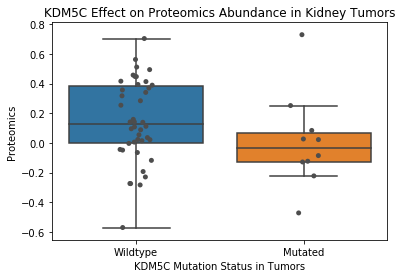

In [6]:
# Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
cis_boxplot = sns.boxplot(data = rc_status, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Kidney Tumors")
cis_boxplot = sns.stripplot(data= rc_status, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

# Compare missense and truncation mutation types

In [8]:
rc_type = f.get_missence_truncation_comparison(rc_object, 'proteomics', gene) 
rc_type_real_measurements = rc_type.dropna(axis=0)
rc_type_real_measurements['binary_mutations'].value_counts()

Truncation    8
Missence      3
Name: binary_mutations, dtype: int64

In [9]:

# Step 4 - T-test comparing means of miss vs trunc effect on cis omics
print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(rc_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

         Comparison   P_Value
0  KDM5C_proteomics  0.038634


Not enough proteomics data for missense to do a valid T-test.

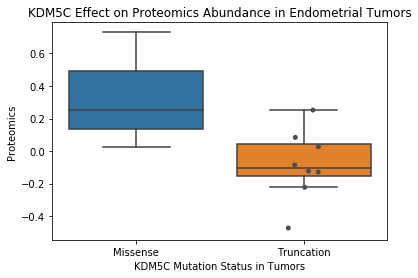

In [26]:
rc_cis_boxplot = sns.boxplot(data = rc_type, x = 'binary_mutations',
                          y = prot_col, order = ["Missense","Truncation"], showfliers = False)  
rc_cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Endometrial Tumors")
rc_cis_boxplot = sns.stripplot(data= rc_type, x = 'binary_mutations',
                            y = prot_col, jitter = True, color = ".3", order = ["Missense","Truncation"])
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()


# Compare common mutations

Find the common mutation types and compare them to the wildtype tumors.

In [126]:
# Count all mutations (including all mutations in a sample)
somatic_mutations = rc_object.get_mutations()
gene_mutations = somatic_mutations.loc[somatic_mutations['Gene'] == gene]
count_all_mut = gene_mutations['Mutation'].value_counts()
count_all_mut

Frame_Shift_Del      8
Nonsense_Mutation    5
Missense_Mutation    4
Splice_Site          2
Frame_Shift_Ins      1
Name: Mutation, dtype: int64

In [128]:
# count real measurements of omics data -if there are multiple mutations they will be shown as a separate index
mutation_prot = rc_object.join_omics_to_mutations(omics_df_name="proteomics",
                                                  mutations_genes=gene, 
                                                  omics_genes=gene)
tumors = mutation_prot.loc[mutation_prot['Sample_Status'] == 'Tumor'] #drop Normal                                                 
measured_omics = tumors.dropna(axis=0)
counts = measured_omics[gene+'_Mutation'].value_counts()
counts

[Wildtype_Tumor]                    42
[Frame_Shift_Del]                    3
[Nonsense_Mutation]                  3
[Missense_Mutation]                  2
[Missense_Mutation, Splice_Site]     1
[Frame_Shift_Ins]                    1
Name: KDM5C_Mutation, dtype: int64

In [129]:
common_mutations = counts[counts.apply(lambda x: x > 4)]
common_mut_list = list(common_mutations.index) 
#common_mut_list.append("Wildtype_Tumor")
common_mut_list = [''.join(x) for x in common_mut_list]
common_mut_list

['Wildtype_Tumor']

Not enough proteomics measuremtns to compare common mutations.

In [133]:
# prepare dataframe for plotting - using the filter takes the mutations column out of lists 
#(one mutation for each sample, filtered to the most common mutation)
filtered_mutation_prot = rc_object.join_omics_to_mutations(omics_df_name="proteomics",
                                                  mutations_genes=gene, 
                                                  omics_genes=gene,
                                                  mutations_filter=['Frame_Shift_Del'])

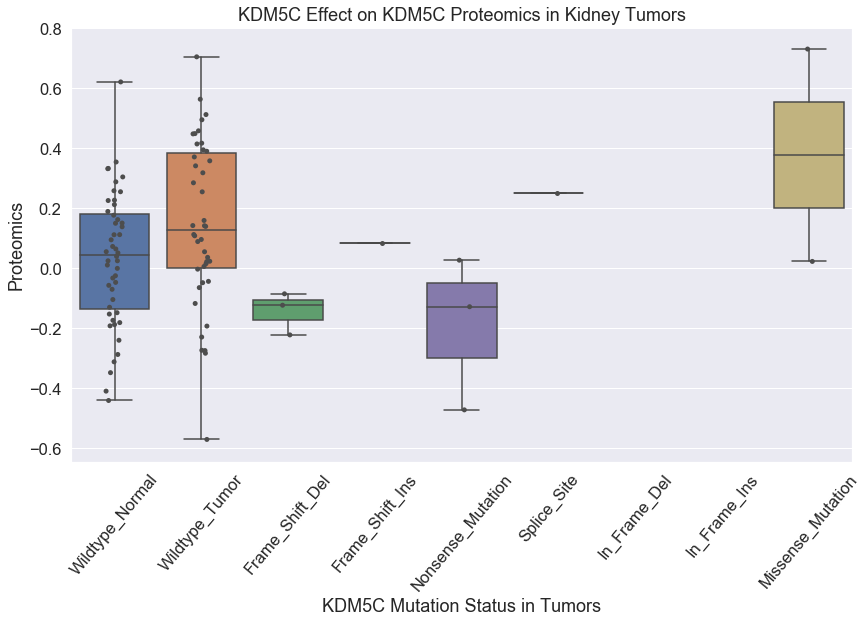

In [135]:
# todo- rotate x 
plt.rcParams['figure.figsize']=(14,8)
sns.set(font_scale = 1.5)
rc_cis_boxplot = sns.boxplot(data = filtered_mutation_prot,
                             x = gene+'_Mutation',
                             y = gene+'_proteomics', 
                             order=['Wildtype_Normal', 'Wildtype_Tumor', 'Frame_Shift_Del', 
                                    'Frame_Shift_Ins', 'Nonsense_Mutation', 'Splice_Site',
                                    'In_Frame_Del', 'In_Frame_Ins', 'Missense_Mutation'],
                             showfliers = False)  
rc_cis_boxplot.set_title(gene + " Effect on " + gene +" Proteomics in Kidney Tumors")
rc_cis_boxplot = sns.stripplot(data= filtered_mutation_prot, 
                               x = gene+'_Mutation',
                               y = gene+'_proteomics', 
                               order=['Wildtype_Normal', 'Wildtype_Tumor', 'Frame_Shift_Del', 
                                    'Frame_Shift_Ins', 'Nonsense_Mutation', 'Splice_Site',
                                    'In_Frame_Del', 'In_Frame_Ins', 'Missense_Mutation'],
                               jitter = True, color = ".3")
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
rc_cis_boxplot.set_xticklabels(rc_cis_boxplot.get_xticklabels(),rotation = 50)
plt.show()
plt.clf()
plt.close()

# Common mutation locations

In [18]:
#work to del later
loc_counts = gene_mutations['Location'].value_counts()
# uncomment the next line to see mutation types with mutation locations
# print(gene_mutations)
loc_counts

p.X374_splice     1
p.X1041_splice    1
p.D1430Hfs*42     1
p.Q139Sfs*95      1
p.D517Y           1
p.K788Sfs*7       1
p.C1205*          1
p.C14W            1
p.P480L           1
p.P962Lfs*16      1
p.T1228S          1
p.R694*           1
p.R681*           1
p.R635Gfs*24      1
p.R68Pfs*6        1
p.R332*           1
p.R198*           1
p.K40Nfs*33       1
p.G384Afs*46      1
p.Q560Hfs*12      1
Name: Location, dtype: int64

No common mutation locations for this gene.

# Analysis of Results

No significant results? data for mutation type is too small.